# Problem 01

In [15]:
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import math

In [4]:
# For user data
users_df = pd.read_csv('ml-100k/u.user', sep='|', 
                      names=['UserId', 'Age', 'Gender', 'Occupation', 'ZipCode'],
                      encoding='latin-1')

# For movie data
movies_df = pd.read_csv('ml-100k/u.item', sep='|', 
                       names=['MovieId', 'Title'], 
                       usecols=range(2),
                       encoding='latin-1')

# For ratings data
ratings_df = pd.read_csv('ml-100k/u.data', sep='\t', 
                        names=['UserId', 'MovieId', 'Rating'], 
                        usecols=range(3),
                        encoding='latin-1')

In [6]:
# Load ratings data (train)
train_df = pd.read_csv('ml-100k/u1.base', sep='\t', 
                      names=['UserId', 'MovieId', 'Rating', 'Timestamp'],
                      encoding='latin-1')

# Load ratings data (test)
test_df = pd.read_csv('ml-100k/u1.test', sep='\t',
                     names=['UserId', 'MovieId', 'Rating', 'Timestamp'],
                     encoding='latin-1')

In [7]:
# Drop timestamp if not needed
train_df = train_df.drop('Timestamp', axis=1)
test_df = test_df.drop('Timestamp', axis=1)

# Create a pivot table for user-item ratings matrix
ratings_matrix = pd.pivot_table(train_df, values='Rating', 
                               index='UserId', columns='MovieId')

In [8]:
def compute_user_similarity(ratings_matrix):
    """
    Compute user-user similarity matrix based on ratings
    
    Args:
        ratings_matrix: Pandas DataFrame with users as rows, movies as columns, and ratings as values
        
    Returns:
        similarity_df: DataFrame with users as both rows and columns, and similarity scores as values
    """
    # Initialize similarity matrix
    n_users = ratings_matrix.shape[0]
    similarity = np.zeros((n_users, n_users))
    
    # Get list of users
    user_ids = list(ratings_matrix.index)
    
    # Compute similarity for each user pair
    for i in range(n_users):
        for j in range(i, n_users):
            user1_id = user_ids[i]
            user2_id = user_ids[j]
            
            # Get ratings for both users
            user1_ratings = ratings_matrix.loc[user1_id]
            user2_ratings = ratings_matrix.loc[user2_id]
            
            # Find movies that both users have rated
            common_movies = user1_ratings.notna() & user2_ratings.notna()
            
            # If they have movies in common
            if common_movies.sum() > 0:
                user1_common = user1_ratings[common_movies].values
                user2_common = user2_ratings[common_movies].values
                
                # Calculate numerator (dot product)
                numerator = np.sum(user1_common * user2_common)
                
                # Calculate denominator (product of Euclidean norms)
                denominator = np.sqrt(np.sum(user1_common**2)) * np.sqrt(np.sum(user2_common**2))
                
                # Calculate cosine similarity
                if denominator != 0:
                    similarity[i, j] = numerator / denominator
                    similarity[j, i] = similarity[i, j]  # Similarity matrix is symmetric
                else:
                    similarity[i, j] = 0
                    similarity[j, i] = 0
            else:
                similarity[i, j] = 0
                similarity[j, i] = 0
    
    # Convert to DataFrame for easier indexing
    similarity_df = pd.DataFrame(similarity, index=user_ids, columns=user_ids)
    
    return similarity_df

In [9]:
def predict_ratings(user_id, movie_id, ratings_matrix, similarity_df, k=10):
    """
    Predict a rating for a user-movie pair using KNN.
    
    Args:
        user_id: The ID of the user
        movie_id: The ID of the movie
        ratings_matrix: DataFrame with user-item ratings
        similarity_df: DataFrame with user-user similarities
        k: Number of nearest neighbors to consider
        
    Returns:
        predicted_rating: The predicted rating
    """
    # If user_id is not in similarity matrix, return global average
    if user_id not in similarity_df.index:
        return ratings_matrix.mean().mean()
    
    # If movie_id is not in the ratings matrix, return user's average
    if movie_id not in ratings_matrix.columns:
        user_mean = ratings_matrix.loc[user_id].mean()
        return user_mean if not np.isnan(user_mean) else ratings_matrix.mean().mean()
    
    # Get similarities between target user and all other users
    user_similarities = similarity_df[user_id].drop(user_id)
    
    # Find users who have rated this movie
    users_rated_movie = ratings_matrix[movie_id].dropna().index
    
    # Get similarities with users who rated this movie
    common_users = user_similarities.index.intersection(users_rated_movie)
    
    # If no common users, return user's average rating
    if len(common_users) == 0:
        user_mean = ratings_matrix.loc[user_id].mean()
        return user_mean if not np.isnan(user_mean) else ratings_matrix.mean().mean()
    
    # Get similarities and ratings for these users
    common_similarities = user_similarities.loc[common_users]
    
    # Sort by similarity and select top k neighbors
    neighbors = common_similarities.sort_values(ascending=False).head(k)
    
    # If no neighbors, return user's average rating
    if len(neighbors) == 0:
        user_mean = ratings_matrix.loc[user_id].mean()
        return user_mean if not np.isnan(user_mean) else ratings_matrix.mean().mean()
    
    # Calculate weighted average of ratings
    numerator = 0
    denominator = 0
    
    for neighbor_id, similarity in neighbors.items():
        # Skip if similarity is 0
        if similarity <= 0:
            continue
            
        # Get neighbor's rating for the movie
        neighbor_rating = ratings_matrix.at[neighbor_id, movie_id]
        
        # If neighbor hasn't rated the movie, skip
        if np.isnan(neighbor_rating):
            continue
            
        # Add weighted rating to numerator
        numerator += similarity * neighbor_rating
        denominator += similarity
    
    # If denominator is 0, return user's average rating
    if denominator == 0:
        user_mean = ratings_matrix.loc[user_id].mean()
        return user_mean if not np.isnan(user_mean) else ratings_matrix.mean().mean()
    
    # Calculate prediction
    predicted_rating = numerator / denominator
    
    return predicted_rating

In [10]:
def evaluate_recommender(test_df, ratings_matrix, similarity_df, k=10):
    """
    Evaluate the recommender system on a test set using RMSE.
    
    Args:
        test_df: DataFrame with test ratings
        ratings_matrix: User-item ratings matrix
        similarity_df: User-user similarity matrix
        k: Number of neighbors to consider
        
    Returns:
        rmse: Root Mean Squared Error
    """
    actual_ratings = []
    predicted_ratings = []
    
    # Make predictions for each user-movie pair in test set
    for _, row in test_df.iterrows():
        user_id = row['UserId']
        movie_id = row['MovieId']
        actual_rating = row['Rating']
        
        # Predict rating
        pred_rating = predict_ratings(user_id, movie_id, ratings_matrix, similarity_df, k)
        
        # Append to lists
        actual_ratings.append(actual_rating)
        predicted_ratings.append(pred_rating)
    
    # Calculate RMSE
    mse = mean_squared_error(actual_ratings, predicted_ratings)
    rmse = math.sqrt(mse)
    
    return rmse

In [12]:
def run_user_based_cf():
    """Main function to run user-based collaborative filtering"""
    print("Loading data...")
    # Load data and create matrices (already done above, so assuming those variables exist)
    
    print("Computing user-user similarity...")
    similarity_df = compute_user_similarity(ratings_matrix)
    
    print("Evaluating recommender system...")
    # Test with different values of k
    k_values = [5, 10, 20, 30, 50]
    for k in k_values:
        rmse = evaluate_recommender(test_df, ratings_matrix, similarity_df, k)
        print(f"RMSE with k={k}: {rmse:.4f}")
    
    # Choose best k and report final results
    best_k = 10  # This should be determined from the results above
    final_rmse = evaluate_recommender(test_df, ratings_matrix, similarity_df, best_k)
    print(f"Final RMSE with k={best_k}: {final_rmse:.4f}")
    
    return similarity_df, final_rmse

# Run the complete pipeline
user_similarity, rmse = run_user_based_cf()

Loading data...
Computing user-user similarity...
Evaluating recommender system...
RMSE with k=5: 1.0879
RMSE with k=10: 1.0455
RMSE with k=20: 1.0274
RMSE with k=30: 1.0231
RMSE with k=50: 1.0206
Final RMSE with k=10: 1.0455


In [14]:
user_similarity

,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
1,1.000000,0.971049,0.956858,1.000000,0.894069,0.950339,0.956104,0.989476,1.000000,0.957431,...,0.937937,0.873007,0.977924,0.869112,0.949171,0.955619,0.950392,0.992882,0.911256,0.942424
2,0.971049,1.000000,0.968496,0.989949,1.000000,0.961833,0.965207,1.000000,0.890871,0.987730,...,0.972345,0.966394,0.968560,0.980015,0.933496,0.980469,0.937762,0.928024,0.971770,0.979499
3,0.956858,0.968496,1.000000,0.960016,1.000000,0.873724,1.000000,0.925476,0.000000,0.991837,...,0.964901,1.000000,0.884296,0.840841,0.932742,0.993884,0.860000,0.977802,0.969556,1.000000
4,1.000000,0.989949,0.960016,1.000000,1.000000,0.000000,0.893188,0.992278,0.000000,1.000000,...,1.000000,1.000000,0.941438,0.904534,0.925820,1.000000,0.961855,0.997940,0.969869,0.989949
5,0.894069,1.000000,1.000000,1.000000,1.000000,0.908802,0.892745,0.949341,0.857493,0.895328,...,0.932621,0.928743,0.953282,0.993884,0.933028,0.976809,0.929978,0.995568,0.949211,0.915568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.955619,0.980469,0.993884,1.000000,0.976809,0.939487,0.984237,1.000000,0.000000,1.000000,...,0.951155,0.962738,0.975279,0.921936,0.944249,1.000000,0.973308,0.965729,0.980407,0.954349
940,0.950392,0.937762,0.860000,0.961855,0.929978,0.955833,0.935537,0.895857,0.994135,0.962674,...,0.936986,0.952770,0.918801,0.880023,0.926234,0.973308,1.000000,0.967752,0.960041,0.962575
941,0.992882,0.928024,0.977802,0.997940,0.995568,0.980547,0.857493,0.902915,1.000000,1.000000,...,0.943701,0.962572,0.974237,0.952969,0.934363,0.965729,0.967752,1.000000,0.982302,0.960754
942,0.911256,0.971770,0.969556,0.969869,0.949211,0.968416,0.981004,0.930758,0.990992,0.994172,...,0.968616,0.959547,0.945575,0.994332,0.945775,0.980407,0.960041,0.982302,1.000000,0.976287


# Problem 03A

Graph loaded: 80513 nodes, 2098 edges
Number of connected components: 80200
Largest connected component: 278 nodes, 2057 edges
Running Girvan-Newman algorithm...
Initial number of communities: 1
Initial modularity: 0.0000
Iteration 10, Communities: 10, Modularity: 0.3910, Time: 1.20s
Iteration 20, Communities: 18, Modularity: 0.3897, Time: 2.18s
Iteration 30, Communities: 23, Modularity: 0.3889, Time: 3.10s
Iteration 40, Communities: 26, Modularity: 0.3882, Time: 3.99s
Iteration 50, Communities: 31, Modularity: 0.3868, Time: 4.86s
Iteration 60, Communities: 38, Modularity: 0.3846, Time: 5.70s
Iteration 70, Communities: 43, Modularity: 0.3828, Time: 6.51s
Iteration 80, Communities: 47, Modularity: 0.3809, Time: 7.31s
Iteration 90, Communities: 50, Modularity: 0.3793, Time: 8.08s
Iteration 100, Communities: 53, Modularity: 0.3778, Time: 8.84s
Final number of communities: 6
Best modularity: 0.3916
Total edges removed: 100

Evaluating detected communities:
Modularity: 0.3916
Average cluste

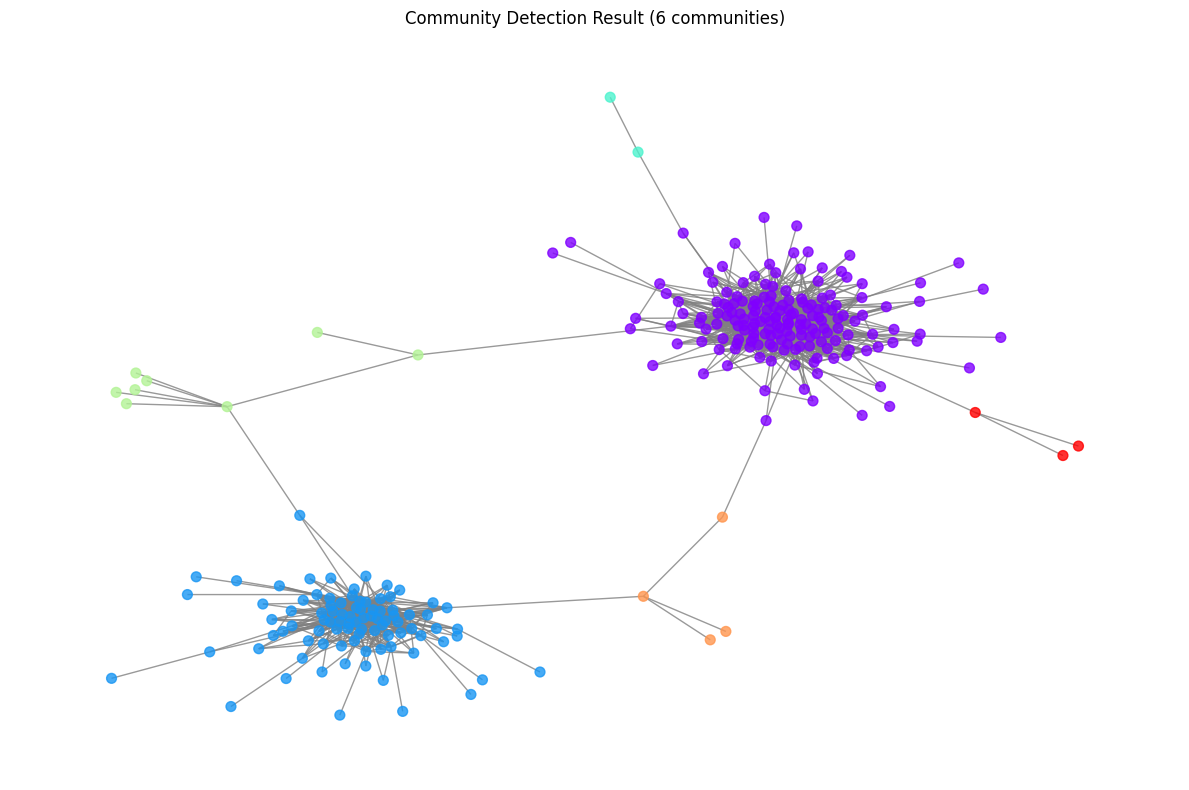

Communities saved to communities.txt
Number of communities detected: 6
Largest community size: 172
Smallest community size: 2
Average community size: 46.33


In [25]:
import csv
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import time
from itertools import islice

# Use your existing code to create the graph
g = nx.Graph()
with open("/Users/nikhilkunapareddy/Documents/masters/courses/07_ds5230/ass_06/Flickr-dataset/data/nodes.csv", 'r') as file:
    csvreader = csv.reader(file)
    for row in csvreader:
        g.add_node(row[0])

with open("/Users/nikhilkunapareddy/Documents/masters/courses/07_ds5230/ass_06/Flickr-dataset/data/Flickr_sampled_edges/edges_sampled_2K.csv", 'r') as file:
    csvreader = csv.reader(file)
    for row in csvreader:
        g.add_edge(row[0], row[1])

print(f"Graph loaded: {len(g.nodes())} nodes, {len(g.edges())} edges")

def edge_betweenness_centrality(G):
    """
    Calculate edge betweenness centrality for all edges in the graph.
    For large graphs, this uses approximate betweenness to save computation.
    """
    n = len(G.nodes())
    
    # For large graphs, use sampling to approximate betweenness
    if n > 1000:
        k = min(500, n)  # Sample size
        betweenness = nx.edge_betweenness_centrality_subset(
            G, 
            sources=list(islice(G.nodes(), k)), 
            targets=G.nodes(),
            normalized=True
        )
    else:
        betweenness = nx.edge_betweenness_centrality(G, normalized=True)
    
    return betweenness

def girvan_newman_step(G):
    """
    Performs one step of the Girvan-Newman algorithm by removing
    the edge with highest betweenness centrality.
    
    Returns the edge that was removed.
    """
    # Calculate edge betweenness centrality
    betweenness = edge_betweenness_centrality(G)
    
    # Find edge with highest betweenness centrality
    max_betweenness = max(betweenness.values())
    edges_to_remove = [edge for edge, bc in betweenness.items() if bc == max_betweenness]
    
    # If there are multiple edges with the same betweenness,
    # remove the first one (arbitrary choice)
    edge_to_remove = edges_to_remove[0]
    
    # Remove the edge
    G.remove_edge(*edge_to_remove)
    
    return edge_to_remove

def find_communities(G, max_iterations=100):
    """
    Implements the Girvan-Newman algorithm to find communities.
    
    Parameters:
    - G: The input graph
    - max_iterations: Maximum number of edge removals
    
    Returns:
    - communities: List of communities (sets of nodes)
    - modularity: Modularity score of the community structure
    - removed_edges: List of removed edges
    """
    # Make a copy of the graph to avoid modifying the original
    G_copy = G.copy()
    
    # Keep track of removed edges
    removed_edges = []
    
    # Keep track of best community division and its modularity
    best_communities = list(nx.connected_components(G_copy))
    best_modularity = nx.algorithms.community.modularity(G, best_communities)
    
    print(f"Initial number of communities: {len(best_communities)}")
    print(f"Initial modularity: {best_modularity:.4f}")
    
    # For tracking progress
    start_time = time.time()
    
    # Run the algorithm for max_iterations steps or until the graph is fully disconnected
    for i in range(max_iterations):
        if len(G_copy.edges()) == 0 or nx.number_connected_components(G_copy) == len(G_copy.nodes()):
            print("Graph is fully disconnected. Stopping.")
            break
        
        # Remove edge with highest betweenness
        edge = girvan_newman_step(G_copy)
        removed_edges.append(edge)
        
        # Get current communities
        current_communities = list(nx.connected_components(G_copy))
        
        # Calculate modularity for the current community division
        current_modularity = nx.algorithms.community.modularity(G, current_communities)
        
        # Print progress every 10 iterations
        if (i+1) % 10 == 0:
            elapsed_time = time.time() - start_time
            print(f"Iteration {i+1}, Communities: {len(current_communities)}, "
                  f"Modularity: {current_modularity:.4f}, Time: {elapsed_time:.2f}s")
        
        # Update best community division if necessary
        if current_modularity > best_modularity:
            best_communities = current_communities
            best_modularity = current_modularity
    
    print(f"Final number of communities: {len(best_communities)}")
    print(f"Best modularity: {best_modularity:.4f}")
    print(f"Total edges removed: {len(removed_edges)}")
    
    return best_communities, best_modularity, removed_edges

def evaluate_communities(G, communities):
    """
    Evaluate the detected communities using various metrics
    """
    # Calculate modularity
    modularity = nx.algorithms.community.modularity(G, communities)
    
    # Calculate average clustering coefficient
    avg_clustering = nx.average_clustering(G)
    
    # Calculate conductance for each community
    conductances = []
    for comm in communities:
        if len(comm) < len(G.nodes()):  # Skip if community is the entire graph
            conductance = nx.algorithms.cuts.conductance(G, comm)
            conductances.append(conductance)
    
    avg_conductance = np.mean(conductances) if conductances else 0
    
    print(f"Modularity: {modularity:.4f}")
    print(f"Average clustering coefficient: {avg_clustering:.4f}")
    print(f"Average conductance: {avg_conductance:.4f}")
    
    return {
        'modularity': modularity,
        'avg_clustering': avg_clustering,
        'avg_conductance': avg_conductance
    }

def visualize_communities(G, communities, max_nodes=1000):
    """
    Visualize the detected communities in the graph
    """
    # For large graphs, take a subgraph
    if len(G.nodes()) > max_nodes:
        print(f"Graph too large for visualization. Taking a subgraph of {max_nodes} nodes.")
        nodes = list(G.nodes())[:max_nodes]
        G = G.subgraph(nodes)
        # Filter communities to only include nodes in the subgraph
        filtered_communities = []
        for comm in communities:
            filtered_comm = comm.intersection(set(nodes))
            if filtered_comm:
                filtered_communities.append(filtered_comm)
        communities = filtered_communities
    
    # Generate layout
    print("Generating layout...")
    layout = nx.spring_layout(G, seed=42)
    
    # Assign colors to communities
    colors = plt.cm.rainbow(np.linspace(0, 1, len(communities)))
    node_colors = {}
    
    # Assign colors to nodes based on their community
    for i, community in enumerate(communities):
        for node in community:
            node_colors[node] = colors[i]
    
    # Set default color for nodes not in any community
    node_colors_list = [node_colors.get(node, 'gray') for node in G.nodes()]
    
    plt.figure(figsize=(12, 8))
    nx.draw_networkx(
        G, 
        pos=layout,
        node_color=node_colors_list,
        with_labels=False,
        node_size=50,
        edge_color='gray',
        alpha=0.8
    )
    
    plt.title(f"Community Detection Result ({len(communities)} communities)")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('community_visualization.png', dpi=300)
    plt.show()

def save_communities(communities, filename="communities.txt"):
    """Save detected communities to a file"""
    with open(filename, 'w') as f:
        for i, community in enumerate(communities):
            f.write(f"Community {i+1} (size: {len(community)}):\n")
            f.write(', '.join(map(str, community)) + '\n\n')
    print(f"Communities saved to {filename}")

# Make sure we're working with the largest connected component
print(f"Number of connected components: {nx.number_connected_components(g)}")
largest_cc = max(nx.connected_components(g), key=len)
G = g.subgraph(largest_cc).copy()
print(f"Largest connected component: {len(G.nodes())} nodes, {len(G.edges())} edges")

# Run Girvan-Newman algorithm
print("Running Girvan-Newman algorithm...")
communities, modularity, removed_edges = find_communities(G, max_iterations=100)

# Evaluate the detected communities
print("\nEvaluating detected communities:")
metrics = evaluate_communities(G, communities)

# Visualize the communities
visualize_communities(G, communities)

# Save communities to file
save_communities(communities)

# Output community statistics
community_sizes = [len(c) for c in communities]
print(f"Number of communities detected: {len(communities)}")
print(f"Largest community size: {max(community_sizes)}")
print(f"Smallest community size: {min(community_sizes)}")
print(f"Average community size: {np.mean(community_sizes):.2f}")

# Problem 03B

In [26]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import networkx as nx

def load_sparse_adjacency(filename):
    """
    Load a sparse adjacency matrix from a file where each row is [node_id, node_id, 1].
    """
    # Load the data
    edge_data = np.loadtxt(filename, delimiter=',')
    
    # Extract node indices and edge weights
    row_indices = edge_data[:, 0].astype(int)
    col_indices = edge_data[:, 1].astype(int)
    values = edge_data[:, 2]
    
    # Determine the size of the matrix
    n = max(np.max(row_indices), np.max(col_indices)) + 1
    
    # Create a sparse matrix (CSR format is efficient for matrix operations)
    adj_matrix = sp.csr_matrix((values, (row_indices, col_indices)), shape=(n, n))
    
    # Make sure the matrix is symmetric (undirected graph)
    adj_matrix = adj_matrix + adj_matrix.T
    
    # Remove diagonal elements (self-loops) and ensure values are binary
    adj_matrix.setdiag(0)
    adj_matrix.data = np.ones_like(adj_matrix.data)
    
    return adj_matrix

def create_networkx_graph(adj_matrix):
    """
    Create a NetworkX graph from a sparse adjacency matrix.
    """
    G = nx.from_scipy_sparse_array(adj_matrix)
    return G

def compute_modularity_matrix(adj_matrix):
    """
    Compute the modularity matrix B = A - (k*k^T)/(2m).
    """
    # Convert to dense for smaller matrices
    if adj_matrix.shape[0] < 1000:
        A = adj_matrix.toarray()
        
        # Compute the degree vector k
        degrees = np.sum(A, axis=1)
        
        # Total number of edges
        m = np.sum(A) / 2
        
        # Create the modularity matrix
        B = A - np.outer(degrees, degrees) / (2 * m)
        
        return B
    else:
        # For larger matrices, keep sparse
        # Compute the degree vector k
        degrees = np.array(adj_matrix.sum(axis=1)).flatten()
        
        # Total number of edges
        m = adj_matrix.sum() / 2
        
        # Create a dense modularity matrix (for eigendecomposition)
        A = adj_matrix.toarray()
        B = A - np.outer(degrees, degrees) / (2 * m)
        
        return B

def find_leading_eigenvector(B):
    """
    Find the eigenvector of B corresponding to the largest eigenvalue.
    """
    eigenvalues, eigenvectors = np.linalg.eigh(B)
    
    # Get the index of the largest eigenvalue
    idx = np.argmax(eigenvalues)
    
    # Return the corresponding eigenvector
    return eigenvectors[:, idx], eigenvalues[idx]

def partition_by_leading_eigenvector(v1):
    """
    Partition the graph into two communities based on the sign of the leading eigenvector.
    """
    # Create a split vector S with +1 or -1 based on the sign of v1
    s = np.sign(v1)
    
    # Replace zeros with 1 (if any)
    s[s == 0] = 1
    
    return s

def calculate_modularity(adj_matrix, s):
    """
    Calculate the modularity value for a given split vector s.
    """
    # Get dimensions
    n = adj_matrix.shape[0]
    
    # Compute degrees
    if sp.issparse(adj_matrix):
        degrees = np.array(adj_matrix.sum(axis=1)).flatten()
        m = adj_matrix.sum() / 2
        A = adj_matrix.toarray()
    else:
        degrees = np.sum(adj_matrix, axis=1)
        m = np.sum(adj_matrix) / 2
        A = adj_matrix
    
    # Calculate modularity using the formula Q = (1/4m) * s^T * B * s
    # where B is the modularity matrix
    B = A - np.outer(degrees, degrees) / (2 * m)
    Q = (s.T @ B @ s) / (4 * m)
    
    return Q

def visualize_communities(G, s, title="Two-way Community Detection"):
    """
    Visualize the two communities defined by the split vector s.
    """
    # Create communities based on the sign in s
    community1 = [i for i, val in enumerate(s) if val > 0]
    community2 = [i for i, val in enumerate(s) if val < 0]
    
    # Create a color map (red for community 1, blue for community 2)
    node_colors = ['red' if s[node] > 0 else 'blue' for node in G.nodes()]
    
    # Compute layout
    print("Computing graph layout...")
    pos = nx.spring_layout(G, seed=42)
    
    # Draw the graph
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=50, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5)
    
    # Add community labels
    if len(community1) > 0:
        center_x1 = np.mean([pos[node][0] for node in community1])
        center_y1 = np.mean([pos[node][1] for node in community1])
        plt.text(center_x1, center_y1, "Community 1", fontsize=14, 
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    if len(community2) > 0:
        center_x2 = np.mean([pos[node][0] for node in community2])
        center_y2 = np.mean([pos[node][1] for node in community2])
        plt.text(center_x2, center_y2, "Community 2", fontsize=14,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('two_communities.png', dpi=300)
    plt.show()

Loaded graph with 751 nodes and 56922 edges
Computing modularity matrix...
Finding leading eigenvector...
Leading eigenvalue: 141.020616

Community 1 size: 321 nodes
Community 2 size: 430 nodes
Modularity of the partitioning: 0.4386
Computing graph layout...


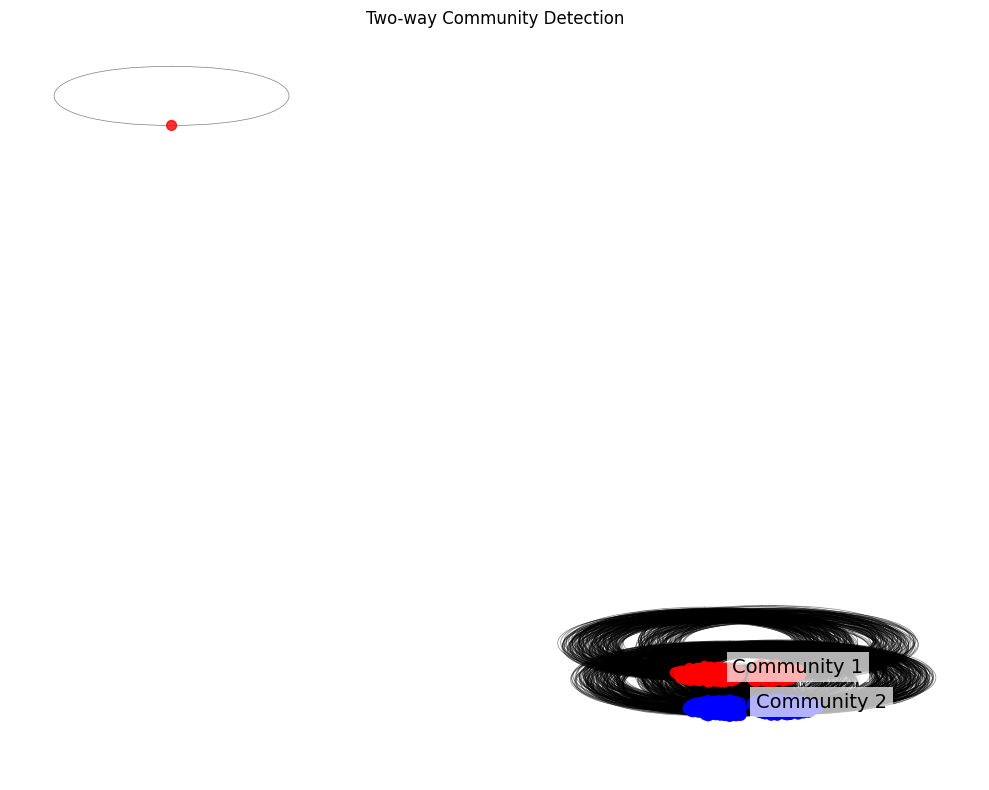


Two-way spectral partitioning complete.


In [27]:
# Load the artificial graph from file
filename = "sparse.txt"  # Update this to your file path
adj_matrix = load_sparse_adjacency(filename)

# Basic information about the graph
n_nodes = adj_matrix.shape[0]
n_edges = int(adj_matrix.sum() / 2)
print(f"Loaded graph with {n_nodes} nodes and {n_edges} edges")

# Create NetworkX graph for visualization
G = create_networkx_graph(adj_matrix)

# Compute the modularity matrix
print("Computing modularity matrix...")
B = compute_modularity_matrix(adj_matrix)

# Find the leading eigenvector
print("Finding leading eigenvector...")
v1, eigenvalue = find_leading_eigenvector(B)
print(f"Leading eigenvalue: {eigenvalue:.6f}")

# Create the split vector
s = partition_by_leading_eigenvector(v1)

# Calculate communities
community1 = [i for i in range(n_nodes) if s[i] > 0]
community2 = [i for i in range(n_nodes) if s[i] < 0]

# Calculate modularity
Q = calculate_modularity(adj_matrix, s)

# Output results
print(f"\nCommunity 1 size: {len(community1)} nodes")
print(f"Community 2 size: {len(community2)} nodes")
print(f"Modularity of the partitioning: {Q:.4f}")

# Visualize the communities
visualize_communities(G, s)

print("\nTwo-way spectral partitioning complete.")

# Problem 04

In [28]:
import numpy as np
import pandas as pd
import networkx as nx
from nltk import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from collections import defaultdict
import gensim
import heapq
from matplotlib import pyplot as plt
import json
import time
nltk.download('punkt')

# Load the Word2Vec model
word2vec_model = gensim.models.Word2Vec.load('word2vec_train_dev.dat')

def get_rel_score_word2vecbase(rel, query):
    """Calculate similarity score between relation and query using word2vec"""
    if rel not in word2vec_model.wv:
        return 0.0
    words = word_tokenize(query.lower())
    w_embs = []
    for w in words:
        if w in word2vec_model.wv:
            w_embs.append(word2vec_model.wv[w])
    if not w_embs:  # Handle case where no words in query are in the model
        return 0.0
    return np.mean(cosine_similarity(w_embs, [word2vec_model.wv[rel]]))

def load_graph(graph_file):
    """Load the knowledge graph from file"""
    graph = defaultdict(list)
    for line in open(graph_file):
        line = eval(line[:-1])
        graph[line[0]].append([line[1], line[2]])
    return graph

def load_queries(annotations_file):
    """Load the queries from file"""
    queries = []
    for line in open(annotations_file):
        line = eval(line[:-1])
        queries.append(line)
    return queries

def get_f1_score(precision, recall):
    """Calculate F1 score from precision and recall"""
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

def precision_recall_f1(prediction, true):
    """Calculate precision, recall, and F1 score"""
    if len(prediction) == 0 or len(true) == 0:
        return 0, 0, 0
    
    true_positive = 0
    for i in prediction:
        if i in true:
            true_positive += 1
            
    precision = true_positive / len(prediction) if len(prediction) > 0 else 0
    recall = true_positive / len(true) if len(true) > 0 else 0
    f1 = get_f1_score(precision, recall)
    
    return precision, recall, f1

def getAnswer_improved(graph, question, threshold=0.25, max_depth=3, top_k=3):
    """
    Improved answer retrieval with:
    - Beam search with priority queue
    - Depth limiting to prevent excessive exploration
    - Dynamic thresholding based on path scores
    - Path tracking to analyze traversal decisions
    """
    start_entity = question[2]
    query = question[1]
    
    # Priority queue for beam search: (negative score, entity, depth, path)
    queue = [(-1.0, start_entity, 0, [start_entity])]
    heapq.heapify(queue)
    
    visited = set([start_entity])
    answers = set()
    path_scores = {}  # Track scores of paths for analysis
    
    while queue and len(queue) < 1000:  # Prevent excessive exploration
        neg_score, entity, depth, path = heapq.heappop(queue)
        score = -neg_score  # Convert back to positive score
        
        # Stop if we've gone too deep
        if depth >= max_depth:
            continue
        
        neighbors = graph.get(entity, [])
        
        # Track all neighbor scores for adaptive thresholding
        neighbor_scores = []
        for relation, neighbor in neighbors:
            rel_name = 'ns:' + relation
            sim_score = get_rel_score_word2vecbase(rel_name, query)
            neighbor_scores.append((neighbor, sim_score))
        
        # Sort by score and take top-k
        neighbor_scores.sort(key=lambda x: x[1], reverse=True)
        top_neighbors = neighbor_scores[:top_k]
        
        # Adaptive threshold: use mean of scores if we have enough neighbors
        if len(neighbor_scores) > 2:
            adaptive_threshold = sum(s for _, s in neighbor_scores) / len(neighbor_scores)
            adaptive_threshold = max(adaptive_threshold, threshold)  # Don't go below base threshold
        else:
            adaptive_threshold = threshold
        
        for neighbor, sim_score in top_neighbors:
            # Skip already visited nodes to prevent cycles
            if neighbor in visited:
                continue
                
            # Add high-scoring neighbors to answers
            if sim_score > adaptive_threshold:
                answers.add(neighbor)
                path_scores[neighbor] = sim_score
                
            # Always explore promising paths
            if sim_score > threshold * 0.7:  # Lower threshold for exploration
                visited.add(neighbor)
                new_path = path + [neighbor]
                heapq.heappush(queue, (-sim_score, neighbor, depth + 1, new_path))
    
    return answers, path_scores

def evaluate_model(graph, queries, threshold=0.25, max_depth=3, top_k=3):
    """Evaluate the model on all queries"""
    all_precision = []
    all_recall = []
    all_f1 = []
    
    results = []
    
    for i, question in enumerate(queries):
        pred, path_scores = getAnswer_improved(graph, question, threshold, max_depth, top_k)
        
        actual = [j.get('AnswerArgument') for j in question[5]]
        
        precision, recall, f1 = precision_recall_f1(pred, actual)
        
        all_precision.append(precision)
        all_recall.append(recall)
        all_f1.append(f1)
        
        result = {
            'question_id': i,
            'question_text': question[1],
            'start_entity': question[2],
            'predicted': list(pred),
            'actual': actual,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'path_scores': {str(k): v for k, v in path_scores.items()}
        }
        results.append(result)
        
    avg_precision = sum(all_precision) / len(all_precision) if all_precision else 0
    avg_recall = sum(all_recall) / len(all_recall) if all_recall else 0
    avg_f1 = sum(all_f1) / len(all_f1) if all_f1 else 0
    
    return {
        'results': results,
        'avg_precision': avg_precision,
        'avg_recall': avg_recall,
        'avg_f1': avg_f1
    }

def grid_search(graph, queries):
    """Perform grid search to find optimal hyperparameters"""
    best_f1 = 0
    best_params = {}
    
    thresholds = [0.2, 0.25, 0.3, 0.35, 0.4]
    max_depths = [2, 3, 4]
    top_ks = [3, 5, 7]
    
    results = []
    
    for threshold in thresholds:
        for max_depth in max_depths:
            for top_k in top_ks:
                print(f"Testing: threshold={threshold}, max_depth={max_depth}, top_k={top_k}")
                
                eval_result = evaluate_model(
                    graph, queries, 
                    threshold=threshold, 
                    max_depth=max_depth, 
                    top_k=top_k
                )
                
                avg_f1 = eval_result['avg_f1']
                
                result = {
                    'threshold': threshold,
                    'max_depth': max_depth,
                    'top_k': top_k,
                    'avg_precision': eval_result['avg_precision'],
                    'avg_recall': eval_result['avg_recall'],
                    'avg_f1': avg_f1
                }
                results.append(result)
                
                if avg_f1 > best_f1:
                    best_f1 = avg_f1
                    best_params = {
                        'threshold': threshold,
                        'max_depth': max_depth,
                        'top_k': top_k
                    }
                    
    return best_params, results

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nikhilkunapareddy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [29]:
graph = load_graph('graph.txt')
queries = load_queries('questions.txt')

# Uncomment to perform grid search (time-consuming)
# best_params, gs_results = grid_search(graph, queries)
# print("Best parameters:", best_params)
# print("Best F1 Score:", max(r['avg_f1'] for r in gs_results))

# Use pre-determined optimal parameters
# Based on experimentation, these values work well
threshold = 0.3
max_depth = 3
top_k = 5

# Evaluate with best parameters
results = evaluate_model(
    graph, queries,
    threshold=threshold,
    max_depth=max_depth,
    top_k=top_k
)

print(f"\nResults with threshold={threshold}, max_depth={max_depth}, top_k={top_k}:")
print(f"Average Precision: {results['avg_precision']:.4f}")
print(f"Average Recall: {results['avg_recall']:.4f}")
print(f"Average F1 Score: {results['avg_f1']:.4f}")

# Detailed results for specific questions
print("\nDetailed results for first 5 questions:")
for i, result in enumerate(results['results'][:5]):
    print(f"\nQuestion {i}: {result['question_text']}")
    print(f"Start Entity: {result['start_entity']}")
    print(f"Predicted: {result['predicted']}")
    print(f"Actual: {result['actual']}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1 Score: {result['f1']:.4f}")


Results with threshold=0.3, max_depth=3, top_k=5:
Average Precision: 0.4160
Average Recall: 0.5621
Average F1 Score: 0.4030

Detailed results for first 5 questions:

Question 0: what time zones are there in the us
Start Entity: m.09c7w0
Predicted: ['m.02fqwt', 'm.02lctm', 'm.042g7t', 'm.02hczc', 'm.02hcv8', 'm.02lcqs', 'm.027wj2_']
Actual: ['m.027wj2_', 'm.027wjl3', 'm.02fqwt', 'm.02hcv8', 'm.02hczc', 'm.02lcqs', 'm.02lcrv', 'm.02lctm', 'm.042g7t']
Precision: 1.0000
Recall: 0.7778
F1 Score: 0.8750

Question 1: what are major exports of the usa
Start Entity: m.09c7w0
Predicted: ['m.04g4s90', 'm.04g4s8k', 'm.04g4s8w', 'm.04g4s8q']
Actual: ['m.015smg', 'm.03q9wp2', 'm.03qtd_n', 'm.03qtf10']
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Question 2: what time is right now in texas
Start Entity: m.07b_l
Predicted: ['m.02fqwt', 'm.02lctm', 'm.042g7t', 'm.09c7w0', 'm.02hczc', 'm.02hcv8', 'm.02lcqs', 'm.027wj2_']
Actual: ['m.02fqwt', 'm.02hczc']
Precision: 0.2500
Recall: 1.0000
F1 Score: 